<a href="https://colab.research.google.com/github/F7FF/cap-comp215-max/blob/main/Green_Beards_and_Ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(This notebook takes a while to load - start now!)

https://www.youtube.com/watch?v=goePYJ74Ydg
https://en.wikipedia.org/wiki/Green-beard_effect

TL:DR - Green beard altruism - HOWEVER, instead of genes being boolean, I'm going to try and model genes as continuous numbers.

# Green beards!?

Green beard altruism is an evolutionary model that was proposed in the 60s to try and explain why organisms sometimes help each other out.

Let's say we have a organism, and the organism has a gene that can be on or off. The green-beard effect can be noticed if the gene meets three key criteria:


*   The gene presents some easy way of identifying organisms with said gene... like a big green beard!
*   Carriers of the gene can recognise other carriers of the gene.
*   Carriers of the gene will help other carriers of the gene in some way.

...when these three criteria are met, we can start to see the green beard effect in nature - that carriers of the gene will help each other far beyond what seems "normal" in nature.

This is an observed phenomenon in some species - certain species of fire ants will occasionally murder each other if they smell different due to certain genes, certain lizards will judge each other's colours, and many more examples that I have not studied enough biology to understand.

*Here, I'm going to try and develop a model to demonstrate the green beard effect, and some ways it can apply to the real world - far beyond biology.*

#The model for today:

The model consists of a massive anthill in a garden. Every morning, the ants emerge from the anthill, form groups, and travel to a random plant, where they the berries on the plant.

However, there are birds that are randomly distributed among the anthills each day, that will eat any ants that travel to that plant. 

At the end of the day, ants return to the anthill. The anthill is refilled by making random new ants.

#The weird part:

Each ant has a "personality" number that dictates their behavior in an interesting way:
- '0.0' ants will always run away at the sight of a bird. Cowards!
- '1.0' ants have massive green beards. Green beard ants will always warn other green beard ants of the birds, but might be eaten first because of their warning. Cowardly ants cannot see the warning - it's a secret handshake, I guess.

...we can think of this as a gene, that has two expressions: it makes the ants altruistic and gives them large green beards that other bearded ants can see.

...ants that are somewhere in between will have varying statistics - a 0.4 ant ('smallbeards', I guess) will have a 40% chance of warning other smallbeards/greenbeards and a 60% chance of running away, for example.

Weakly bearded ants arn't very good at spotting beards, though. Two fully bearded ants will always see each other, but a 0.5 ant will only correctly see another 0.5's beard 25% of the time.

Although greenbeards might seem like they have an advantage 

More on this later, since I'm going to experiment with all kinds of values here.




# First: Laying out the classes.

In [399]:
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [400]:
class Ant:
  def __init__(self, p = None):
    if(p != None):
      self.p = p
    else:
      self.p = random.random()
  def clone(self): #returns a new identical ant - useful for reproduction algorithms
    return Ant(p=self.p)
  def seesbeard(self, other): #call this when another ant looks for a beard - returns True or False randomly
    return self.p < other.p #(self.p * other.p) > random.random()
  def seesbird(self): #returns True or False as to whether an ant sees any particular bird (depending on p)
    return random.randint(0,1) == 0 #self.p > random.random()
  def chooses_to_yell(self): #returns True or False if a particular ant feels like yelling about a bird
    return self.p > random.random()

class Anthill:
  def __init__(self, antcount, p = None): #n = target number of ants
    self.antcount = antcount
    if(p == None):
      self.ants = [Ant() for x in range(antcount)]
    else:
      self.ants = [Ant(p=p) for x in range(antcount)]
  def distrobution(self): #returns a convenient list representing the distrobution of p among the ants in a hill
    return sorted([x.p for x in self.ants])
  def averagep(self): #returns the average p value of the ants in the hill
    return sum(self.distrobution())/len(self.ants)
  def step(self, numplants, birdprobability, birdblindness): #runs the model for one day - birdprobability is the probability of a plant having a bird, birdblindness is the probability of a yelling ant surviving without being eaten
    #first, scramble the ants into groups
    groups = [[] for x in range(numplants)]
    random.shuffle(self.ants) #shuffle the anthill to make this random
    for x in range(len(self.ants)): #iterate over each ant - put it in a group according to it's position in the shuffled hill
      groups[(x*numplants)//len(self.ants)].append(self.ants[x])
    self.ants = []
    #put random birds on the plants
    birds = [random.random() < birdprobability for x in range(numplants)]
    #now - iterate over every single plant, and see what happens at each one
    for plant in range(numplants):
      if(not birds[plant]): #if this plant doesn't have a bird...
        for ant in groups[plant]:
          self.ants.append(ant) #put the ants back in the anthill, nice and safely
      else: #if this plant DOES have a bird...
        while(len(groups[plant]) != 0): #iterate until all ants have fled or been eaten
          if(not groups[plant][0].seesbird()): #if the leading ant does not see the bird...
            groups[plant].pop(0) #...the bird eats the ant. the other ants march on.
            continue
          if(not groups[plant][0].chooses_to_yell()): #if the leader of the group decides not to yell...
            self.ants.append(groups[plant].pop(0)) #pop the leader off the group and put them back in the anthill. the other ants march on.
            continue
          #if the leader of the group sees the bird and decides to yell...
          for x in reversed(range(1, len(groups[plant]))): #iterate over the other ants (backwards, so that popping doesn't mess up the pointers) (skipping the leader of course)
            if(groups[plant][0].seesbeard(groups[plant][x])): #if the leader sees the other ant has a beard...
              self.ants.append(groups[plant].pop(x)) #the leader tells the other ant to run away
            #if the other ant does not have a visible beard, nothing happens
          #after warning other ants...
          if(birdblindness < random.random()): #if the bird sees the yelling ant...
            groups[plant].pop(0) #...the bird eats the ant
            continue
          self.ants.append(groups[plant].pop(0)) #if the yelling ant isn't seen, they run back to the anthill.
    #ALL ANTS ARE NOW BACK IN THE ANTHILL
  def reproduce(self, method = "rand"): #fill up with ants again
    for x in range(self.antcount - len(self.ants)):
      if(method == "clone"):
        self.ants.append(random.choice(self.ants).clone()) #make a new clone
      elif(method == "mutateclone"):
        self.ants.append(Ant(p=mutate(random.choice(self.ants).p))) #make a new clone with some error 
      elif(method == "pair"):
        self.ants.append(Ant(p=(random.choice(self.ants).p+random.choice(self.ants).p)/2)) #technically, it's possible for this to select the same ant twice, but (besides being unrealistic) that doesn't really matter
      elif(method == "rand"):
        self.ants.append(Ant()) #make a new random ant
      
def mutate(p, e=0.02): #randomly vary a P as a mutation
  newp = p + random.random()*e*2 - e
  return min(max(newp, 0), 1)

#I was thinking of making the plants their own seperate class, but I didn't think that would be too necessary. the Ant class already seems pretty useless, since it's a glorified float.



#Allright - simple experiment time!

First: A simple model to demonstrate how this works.

In this simulation, there are 1000 ants, 200 plants, a 10% chance a plant has a bird, and birds are at 50% blindness (they will eat 50% of yelling beard ants).

Random ants are created in to replace dead ones.

In [401]:
foo = Anthill(500) #start off with an evenly distributed anthill
histogram = []
for x in range(2000):
  histogram.append(foo.distrobution())
  foo.step(50, 0.1, 0.8) #iterate for 1000 days - 200 plants, 10% chance a plant has a bird, birds are only 50% blind (will see 50% of yellers)
  foo.reproduce()

First, let's take the average of the ant's personalities over time and plot them.

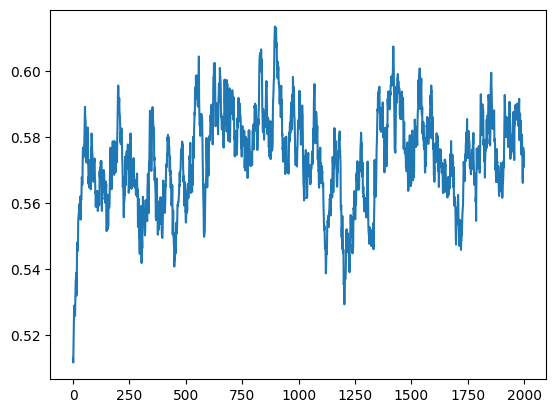

In [402]:
averages = [sum(x)/len(x) for x in histogram]
plt.plot(averages)

Here, we can very clearly see that - although we initially started at an average personality of 0.5 - we very quickly trend upwards to ~0.56 and (roughly) stabilize. The simulation is working! The unbearded ants are dying more frequently, and thus the population is mostly bearded. The system stabilizes when the higher death rate of unbearded ants is balanced out by the smaller number of bearded ants (around 42% - not much, but definitely there)

I like this graph of averages - let's make it into a function so it's easier to investigate.

In [403]:
def anthill_averages_random(foo, plants, birdchance, birdblindness, iterations, method):
  histogram = []
  for x in range(iterations):
    histogram.append(foo.distrobution())
    foo.step(plants, birdchance, birdblindness)
    foo.reproduce(method)
  return [sum(x)/len(x) for x in histogram]

...now, we can easily find the histogram for any anthill Foo.

Let's experiment with different starting conditions...

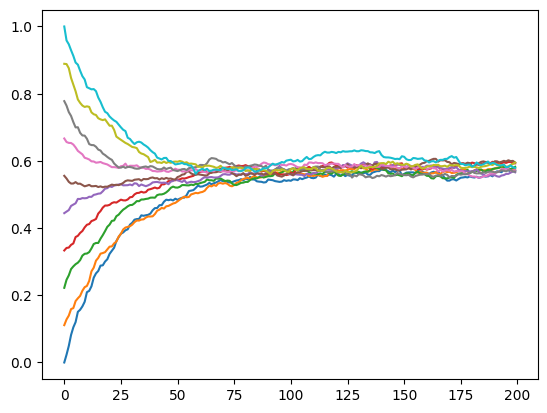

In [404]:
results = []
for startingcondition in range(10):
  biased_hill = Anthill(500, p=startingcondition/9)
  results.append(anthill_averages_random(biased_hill, 50, 0.1, 0.8, 200, "rand"))
plt.plot(list(zip(*results)))

...here we can see MUCH MORE CLEARLY that, with the settings we've set, greenbeards will end up dominating and converging to a point. In this case, the point is defined by the spot where the replacement rate of cowards is around equal to the percentage of cowards killed each turn - which will be lower if there are fewer cowards around.

# Self-Modifying System

Now, let's try out the same experiment, but this time, the ants self-replicate (with small mutations!) instead of appearing randomly out of thin air. This means the current gene pool is a factor in the next, which will make for interesting results.

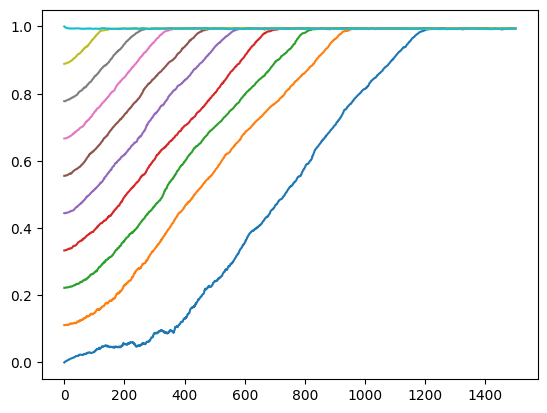

In [405]:
results = []
for startingcondition in range(10):
  biased_hill = Anthill(500, p=startingcondition/9)
  results.append(anthill_averages_random(biased_hill, 50, 0.3, 0.8, 1500, "mutateclone"))
results = list(zip(*results)) #rotate 2d
plt.plot(results)

This is FASCINATING - we can see that, no matter what the starting gene pool is, we will end up with complete green beard dominance.

Last time, the cowardly ants still stood a chance, since they were being replaced from outside - but now, there is no more steady stream of external ants, so the only way for cowardly ants to multiply is for them to... multiply.

...let's study the slope of these lines over time, to see if we can pick apart some trends...

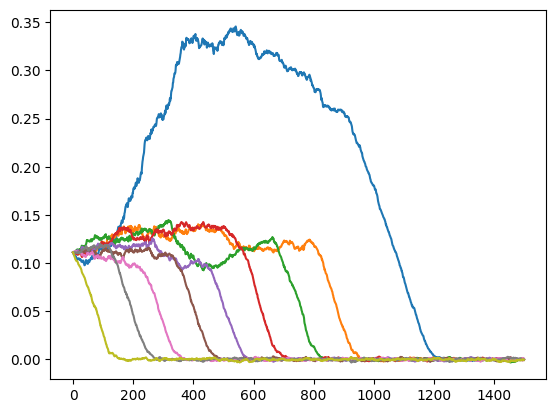

In [406]:
ds = [[x[n]-x[n-1] for n in range(1, len(x))] for x in results]
plt.plot(ds)

*(this plots change in greenbeardiness on Y, time on X)*

Notice that we see a very rough bell curve. This is because in the beginning, greenbeards don't do very well, since there arn't many of each other to help, but as the greenbeard ratio approaches 50%, suddenly many greenbeards will actually experience being warned and will be able to reproduce.

I think the only reason the derivative stops is because, well, you can't get any more greenbeardy than 1.

Let's study this graph in different environments... maybe we'll be able to do something interesting.

# Modelling Multiple Attractors

Here (see above), I've changed the simulation a bit - birds are now much more dangerous, going from 80% blind to 5% blind (meaning 95% of yellers will be eaten now). Groups are smaller, so fewer ants will be warned by a yell. There are far more birds, too. Now, greenbeards have much less gain for far more risk.


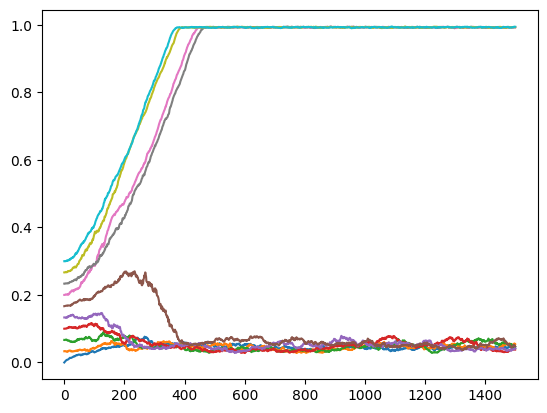

In [407]:
results = []
for startingcondition in range(10):
  biased_hill = Anthill(500, p=startingcondition/30)
  results.append(anthill_averages_random(biased_hill, 70, 0.4, 0.05, 1500, "mutateclone")) 
results = list(zip(*results)) #rotate 2d
plt.plot(results)


...This graph is going to depend a lot on the RNG of this experiment, but you should notice some trends.


*   Anthills that start off with a lot of greenbeards rapidly become completely filled with them.
*   Anthills that start with fewer greenbeards rise a little bit (~10%) but are unable to make the "leap" to the high-greenbeard-state.
*   Very rarely, anthills may suddenly drop in greenbeardiness and rapidly become cowardly. I believe this is because middle-ish anthills sometimes evolve rare cowardice genes, which will extremely suddenly spread, but we can't see them build up since we're only taking an average.

**This is because, in this simulation, we've suddenly gained another stable point.**

An anthill with many greenbeards is stable, since they will always warn each other and many lives will be saved.

An anthill with many cowardly ants is also stable, since any greenbeard that tries to be helpful with probably be eaten without helping anyone (since it's unlikely there are any other greenbeards listening).

Hence, we end up with a constant (looks like it's around 0.22...?) - if an anthill is above this constant, it will tend to evolve greenbeardism, but if it is below this constant, it will tend to evolve cowardice.

# I think this is very interesting:

Think about all the genes that WERE expressed in humans but never caught on because they never reached a critical mass! Think about whether or not this pertains to human interaction, both at the friend-group level AND at the cultural level! This model only has four dimensions (ants per plant, bird-on-plant-chance, bird-sees-yeller-chance, maximum mutation per generation)... imagine how complex actual betrayal systems can get!

We can model these systems with differential equations

$\frac{\text{d}g}{\text{d}t}=\frac{\text{d}b}{\text{d}t}-\frac{\text{d}y}{\text{d}t}-\frac{\text{d}d}{\text{d}t}$

where g is the number of greenbeards per second, b is the number of greenbeard births (itself a function of g), y is the number of yellers that got eaten, while d is the number of deaths from failing to see a bird... oh dear. Well, point being - this is a differential equation that (I think) is self-dependent, which (usually) means this is a somewhat chaotic system (I think), which means... this is going to be absolutely impossible to predict. Just like real life social interactions, or genome adoptions, or cultural conflicts, or this, or that, or... you get my point. What we're doing here is mixing computer science with philosophy, which is a very weird thing to do, but very interesting.

...sorry for the ramble, I just think this is cool. It also gives me hope that being nice can actually get you somewhere!


# Heatmap

In order to maybe get a glimpse of some deeper statistics of this model, I'm going to construct similar graph to the ones already made, but as a heatmap.


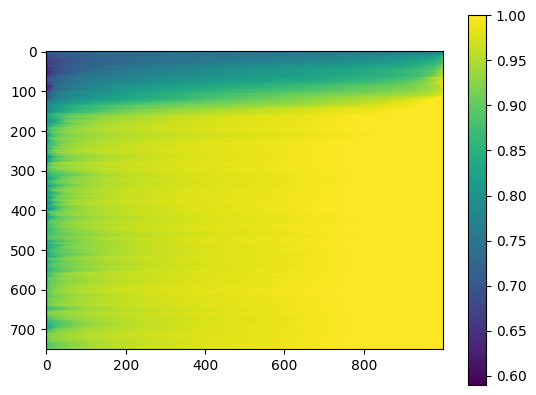

In [408]:
foo = Anthill(1000, p=0.75) #start off with an evenly distributed anthill
histogram = []
for x in range(750):
  histogram.append(foo.distrobution())
  foo.step(500, 0.5, 0) #iterate for 1000 days - 200 plants, 10% chance a plant has a bird, birds are only 50% blind (will see 50% of yellers)
  foo.reproduce("mutateclone")


plt.imshow(histogram, cmap='viridis')
plt.colorbar()
plt.show()

(Time goes top to bottom, X axis represents each individual ant [sorted].)

(refresh the cell until you see sharp horizontal divisions between colour patches!... I mean, it still looks watercolour, but it's sharper than expected.)

# This is interesting too:

...I can't be sure of what you're seeing, but what I'm seeing is (going from top to bottom) a very yellow anthill (mostly greenbeard) slowly becoming a cowardly anthill.

What's interesting, though, is that we're seeing very sharp horizontal lines between different relatively stable states, which I can't really explain. It seems like I've accidentally stumbled upon "subspecies", where it's not as simple as "cowards outcompete greenbeards", but p=1.0 ants are being outcompeted by a minority of p=0.6 ants, which immediately take over... and are then outcompeted by a small minority of 0.4 ants, and so on. The lines are sharp, which means that, for some reason, p=0.5 ants were not viable (otherwise, they would occupy that space and make a smoother transition, like the colour gradient on the right).

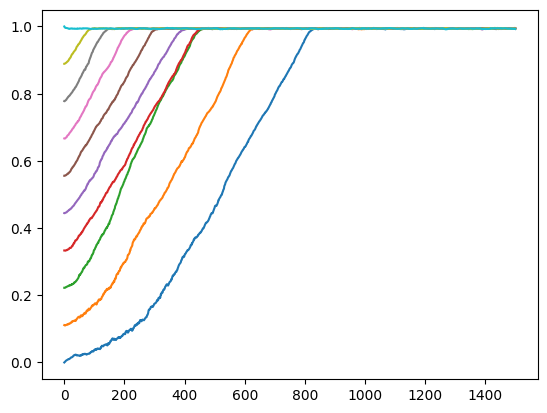

In [409]:
results = []

#Ant.seesbeard = lambda a,b : (a.p * b.p) > random.random()

for startingcondition in range(10):
  biased_hill = Anthill(500, p=startingcondition/9)
  results.append(anthill_averages_random(biased_hill, 50, 0.4, 0.5, 1500, "mutateclone")) 
results = list(zip(*results)) #rotate 2d
plt.plot(results)